In [1]:
import os
import json

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style='darkgrid')
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import albumentations as A
from sklearn import metrics as sk_metrics

In [2]:
BASE_DIR = '../input/cassava-leaf-disease-classification/'

In [3]:
os.listdir(BASE_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [4]:
with open(os.path.join(BASE_DIR, 'label_num_to_disease_map.json')) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
    
print(json.dumps(map_classes, indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [5]:
input_files = os.listdir(os.path.join(BASE_DIR, 'train_images'))
print(f'Number of train images: {len(input_files)}')

Number of train images: 21397


In [6]:
image_shapes = dict()
for image_name in os.listdir(os.path.join(BASE_DIR, 'train_images'))[:300]:
    image = Image.open(os.path.join(BASE_DIR, 'train_images', image_name))
    if image.size not in image_shapes:
        image_shapes[image.size] = 1
    else:
        image_shapes[image.size] += 1

image_shapes

{(800, 600): 300}

In [7]:
df_train = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))

df_train['class_name'] = df_train['label'].map(map_classes)

df_train

image_id  label                           class_name
0      1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1      1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2       100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3      1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4      1000812911.jpg      3         Cassava Mosaic Disease (CMD)
...               ...    ...                                  ...
21392   999068805.jpg      3         Cassava Mosaic Disease (CMD)
21393   999329392.jpg      3         Cassava Mosaic Disease (CMD)
21394   999474432.jpg      1  Cassava Brown Streak Disease (CBSD)
21395   999616605.jpg      4                              Healthy
21396   999998473.jpg      4                              Healthy

[21397 rows x 3 columns]

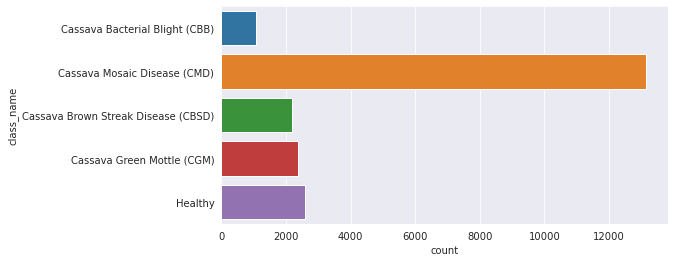

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(y='class_name', data=df_train);

Cassava Mosaic Disease(CMD)のクラスは状況次第では
ダウンサンプリングしてもいいのかもしれない。

In [9]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for idx, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, idx+1)
        image = Image.open(os.path.join(BASE_DIR, 'train_images', image_id))
        
        plt.imshow(image)
        plt.title(f'Class: {label}', fontsize=12)
        plt.axis('off')
        
    plt.show()

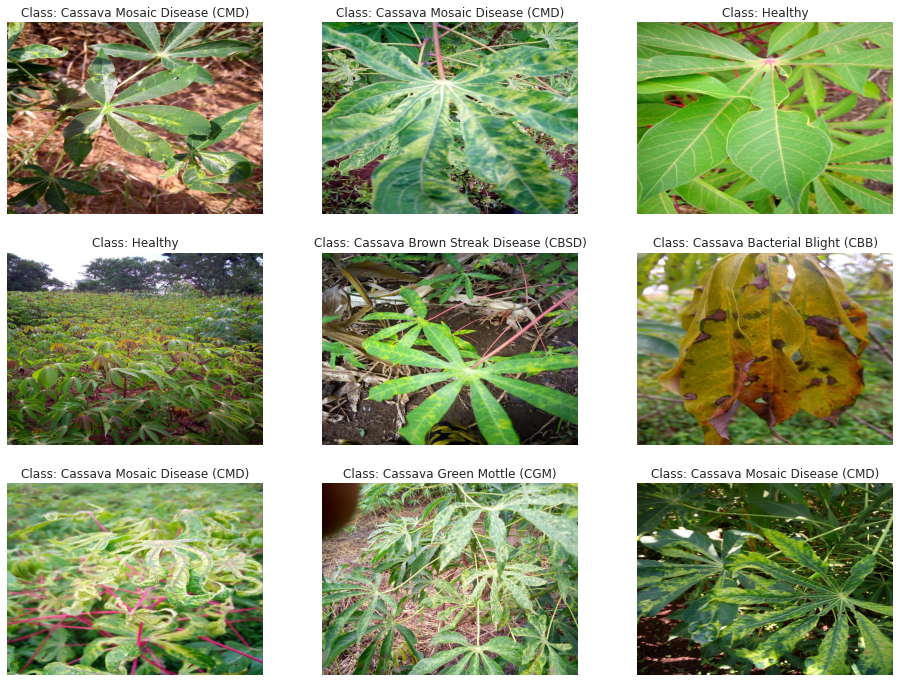

In [10]:
tmp_df = df_train.sample(9)
image_ids = tmp_df['image_id'].values
labels = tmp_df['class_name'].values

visualize_batch(image_ids, labels)

Total train for class 0: 1087
class 0: Cassava Bacterial Blight (CBB)


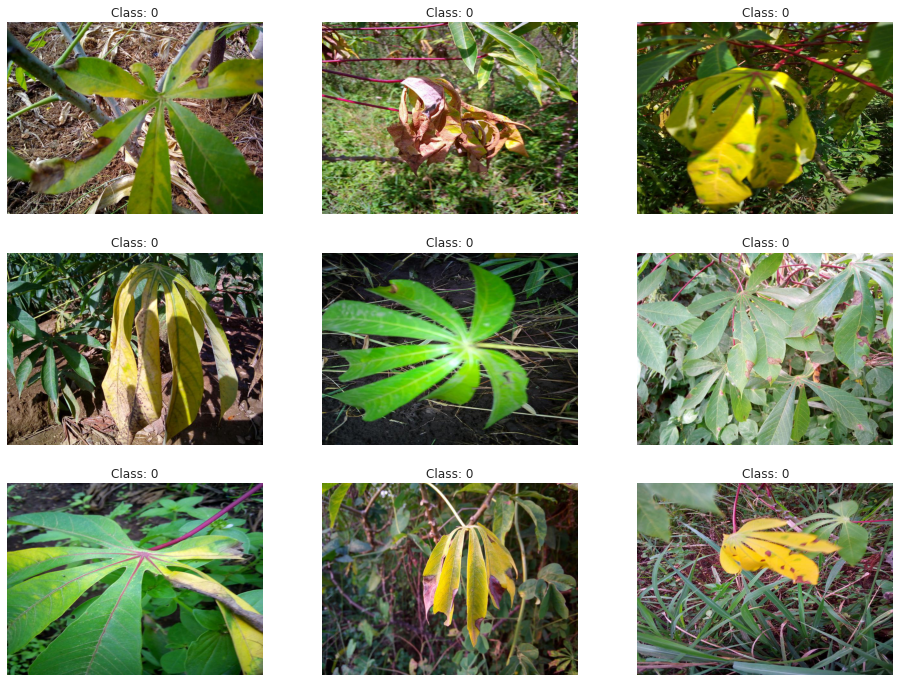

In [11]:
tmp_df = df_train[df_train['label'] == 0]
print(f'Total train for class 0: {tmp_df.shape[0]}')
print(f'class 0: {map_classes[0]}')

tmp_df = tmp_df.sample(9)
image_ids = tmp_df['image_id'].values
labels = tmp_df['label'].values

visualize_batch(image_ids, labels)

Total train for class 1: 2189
class 1 : Cassava Brown Streak Disease (CBSD)


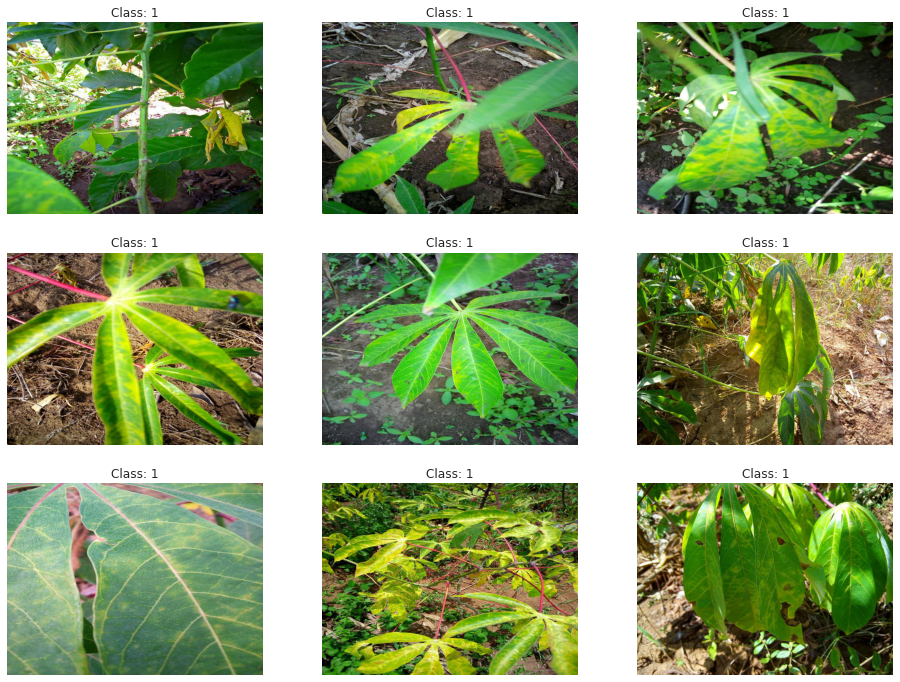

In [12]:
tmp_df = df_train[df_train['label'] == 1]
print(f'Total train for class 1: {tmp_df.shape[0]}')
print(f"class 1 : {map_classes[1]}")

tmp_df = tmp_df.sample(9)
image_ids = tmp_df['image_id'].values
labels = tmp_df['label'].values

visualize_batch(image_ids, labels)

Total train for class 2: 2386
class 2 : Cassava Green Mottle (CGM)


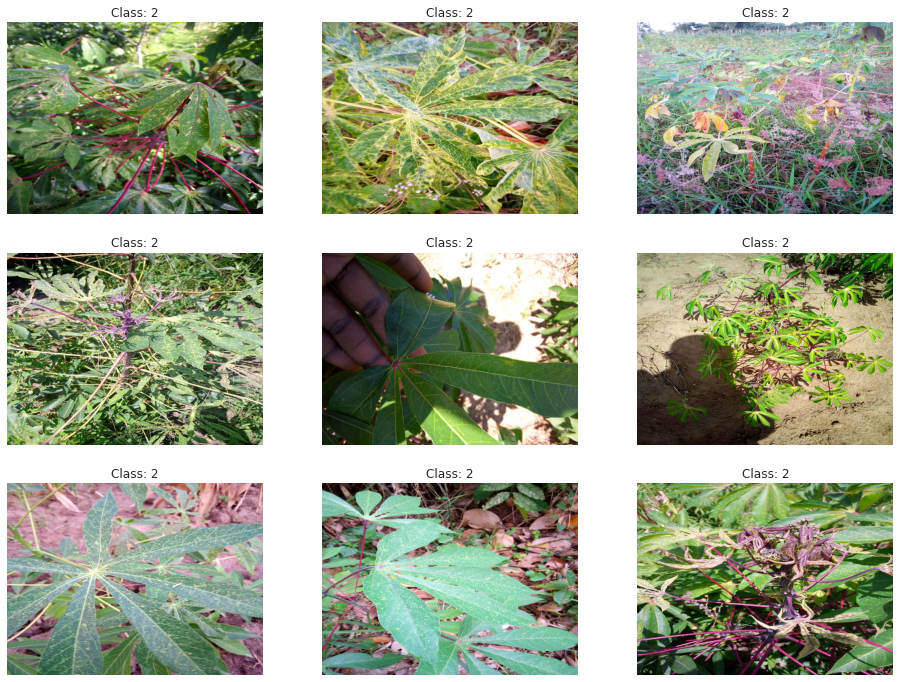

In [13]:
tmp_df = df_train[df_train['label'] == 2]
print(f'Total train for class 2: {tmp_df.shape[0]}')
print(f"class 2 : {map_classes[2]}")

tmp_df = tmp_df.sample(9)
image_ids = tmp_df['image_id'].values
labels = tmp_df['label'].values

visualize_batch(image_ids, labels)

Total train for class 3: 13158
class 3 : Cassava Mosaic Disease (CMD)


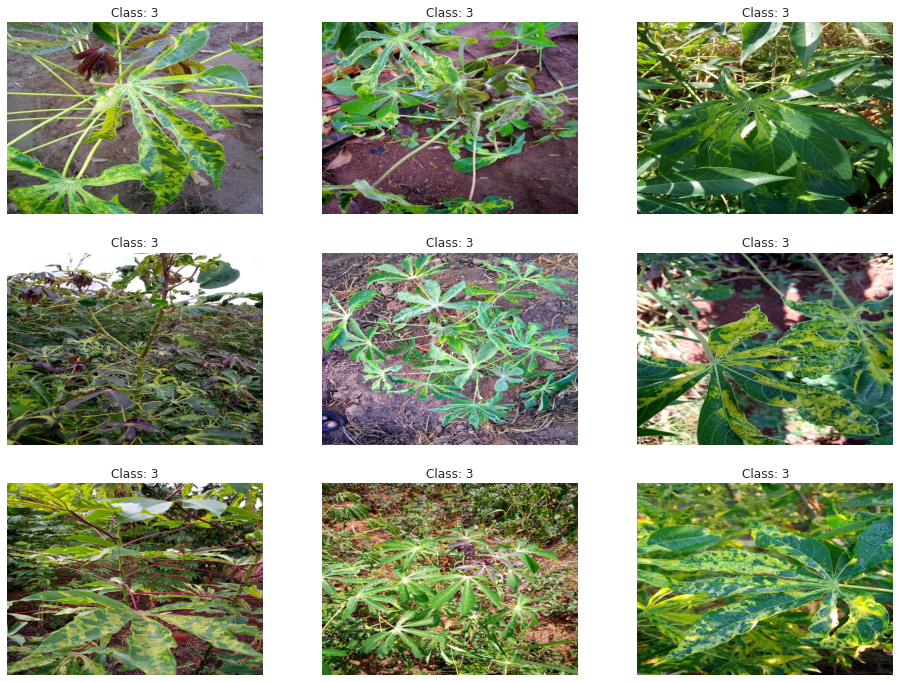

In [14]:
tmp_df = df_train[df_train['label'] == 3]
print(f'Total train for class 3: {tmp_df.shape[0]}')
print(f"class 3 : {map_classes[3]}")

tmp_df = tmp_df.sample(9)
image_ids = tmp_df['image_id'].values
labels = tmp_df['label'].values

visualize_batch(image_ids, labels)

Total train for class 4: 2577
class 4 : Healthy


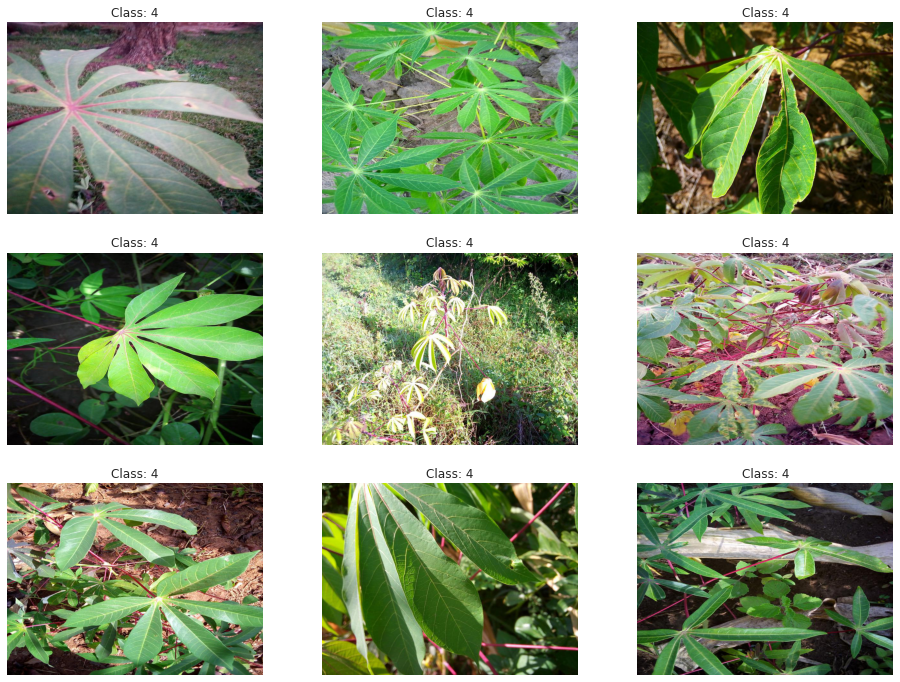

In [15]:
tmp_df = df_train[df_train['label'] == 4]
print(f'Total train for class 4: {tmp_df.shape[0]}')
print(f"class 4 : {map_classes[4]}")

tmp_df = tmp_df.sample(9)
image_ids = tmp_df['image_id'].values
labels = tmp_df['label'].values

visualize_batch(image_ids, labels)

- 人が写っている画像を発見。誤認識の可能性になり得るか...?
- もっと画像を見れば、予想とは違う映り方をしてるものが出てくるかもしれない

In [16]:
df_sub = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv', index_col=0)
df_sub

label
image_id             
2216849948.jpg      4

In [17]:
os.listdir(os.path.join(BASE_DIR, 'test_images'))

['2216849948.jpg']

In [18]:
for pred_class in range(0, 5):
    y_true = df_train['label'].values
    y_pred = np.full_like(y_true, pred_class)
    print(f'accuracy score(predict {pred_class}) : {sk_metrics.accuracy_score(y_true, y_pred):.3f}')

accuracy score(predict 0) : 0.051
accuracy score(predict 1) : 0.102
accuracy score(predict 2) : 0.112
accuracy score(predict 3) : 0.615
accuracy score(predict 4) : 0.120


In [19]:
df_sub['label'] = 4
df_sub.to_csv('submission.csv')

In [20]:
data_train = [0.051, 0.102, 0.112, 0.615, 0.120]
data_LB = [0.048, 0.106, 0.103, 0.602, 0.139]

In [24]:
data = pd.DataFrame({
    'train': data_train, 
    'public': data_LB
})
data

train  public
0  0.051   0.048
1  0.102   0.106
2  0.112   0.103
3  0.615   0.602
4  0.120   0.139

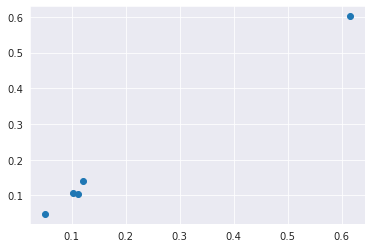

In [27]:
plt.scatter('train', 'public', data=data)

In [29]:
data.corr()

train    public
train   1.000000  0.998871
public  0.998871  1.000000

- trainデータとpublicテストデータの分布はほぼ完全に同じ。
- privateテストデータの分布もほぼ同じと見て良さそう。
- データの分布の乖離によるシェイクの可能性はあんまりなさそう。
- ただ、個別の写真の映り方は今後も見ないといけない。